In [1]:
import copy
import os
import sys
import time

import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from helper import df_to_latex, fig_path, set_figsize, tab_path
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Import code from src
sys.path.insert(0, '../nqs/')
import nqs  # noqa

# Set plot and dataframe style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"
params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }

plt.rcParams.update(params)
plt.rc('text', usetex=True)

pd.set_option('display.max_columns', 50)

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

In [3]:
df_rwm_lr = pd.read_csv("../data/interact_rwm_batch1000_lr_0_05.csv")
df_rwm_lr

,energy,std_error,variance,accept_rate,sem_energy,sem_std_error,sem_variance,sem_accept_rate,nparticles,dim,eta,scale,nvisible,nhidden,mcmc_alg,nsamples,training_cycles,training_batch
0,3.187310,0.010595,3.085175,0.265763,0.005061,0.002002,0.896828,0.000362,2,2,0.05,1.0,4,1,rwm,262144,500000,1000
1,3.069732,0.010593,3.462659,0.299220,0.004036,0.000828,0.456734,0.000361,2,2,0.05,1.0,4,2,rwm,262144,500000,1000
2,3.067219,0.008517,3.827063,0.304742,0.003246,0.000808,0.957071,0.000408,2,2,0.05,1.0,4,3,rwm,262144,500000,1000
3,3.068194,0.011336,4.721258,0.302886,0.005856,0.002197,1.598826,0.000278,2,2,0.05,1.0,4,4,rwm,262144,500000,1000
4,3.375101,0.009805,3.866879,0.305380,0.003343,0.000359,0.925513,0.000452,2,2,0.05,1.0,4,5,rwm,262144,500000,1000
5,3.059188,0.008007,2.128432,0.303141,0.001439,0.000344,0.113748,0.000352,2,2,0.05,1.0,4,6,rwm,262144,500000,1000
6,3.077855,0.008906,2.420098,0.295167,0.003326,0.000801,0.230675,0.000630,2,2,0.05,1.0,4,7,rwm,262144,500000,1000
7,3.100629,0.009560,2.578466,0.294461,0.003188,0.000746,0.187973,0.000512,2,2,0.05,1.0,4,8,rwm,262144,500000,1000


In [4]:
# 1e6 max_iter
df_rwm_lr_tr2 = pd.read_csv("../data/interact_rwm_batch1000_lr_0_05_tr2.csv")
df_rwm_lr_tr2

,energy,std_error,variance,accept_rate,sem_energy,sem_std_error,sem_variance,sem_accept_rate,nparticles,dim,eta,scale,nvisible,nhidden,mcmc_alg,nsamples,training_cycles,training_batch
0,3.188497,0.009629,2.921865,0.263677,0.004348,0.001298,0.659484,0.000349,2,2,0.05,1.0,4,1,rwm,262144,1000000,1000
1,3.075402,0.012136,4.722460,0.296472,0.003823,0.003125,1.384841,0.000402,2,2,0.05,1.0,4,2,rwm,262144,1000000,1000
2,3.071465,0.008676,2.694317,0.303814,0.002992,0.000687,0.243925,0.000456,2,2,0.05,1.0,4,3,rwm,262144,1000000,1000
3,3.102270,0.010133,3.277159,0.293341,0.003580,0.000626,0.513635,0.000456,2,2,0.05,1.0,4,4,rwm,262144,1000000,1000
4,3.116659,0.009870,3.401688,0.291357,0.003240,0.000690,0.700171,0.000433,2,2,0.05,1.0,4,5,rwm,262144,1000000,1000
5,3.093847,0.008854,2.376350,0.304642,0.003007,0.000751,0.323537,0.000516,2,2,0.05,1.0,4,6,rwm,262144,1000000,1000
6,3.069574,0.012879,6.090345,0.301912,0.003540,0.003583,2.917116,0.000406,2,2,0.05,1.0,4,7,rwm,262144,1000000,1000
7,3.062086,0.009447,3.297073,0.304599,0.002377,0.000555,0.773855,0.000368,2,2,0.05,1.0,4,8,rwm,262144,1000000,1000


### Different eta

In [2]:
df_rwm = pd.read_csv("../data/interact_rwm_batch1000.csv")
df_rwm

,energy,std_error,variance,accept_rate,sem_energy,sem_std_error,sem_variance,sem_accept_rate,nparticles,dim,eta,scale,nvisible,nhidden,mcmc_alg,nsamples,training_cycles,training_batch
0,3.301369,0.011415,3.106046,0.239844,0.004013,0.000983,0.365024,0.000540,2,2,0.5,1.0,4,1,rwm,262144,500000,1000
1,3.338470,0.012285,4.705644,0.237206,0.006963,0.001339,1.658320,0.000668,2,2,0.5,1.0,4,2,rwm,262144,500000,1000
2,3.353332,0.023215,36.539066,0.238659,0.007287,0.007694,31.085807,0.000269,2,2,0.5,1.0,4,3,rwm,262144,500000,1000
3,3.344206,0.009622,19.595523,0.238696,0.003555,0.003456,18.070643,0.000309,2,2,0.5,1.0,4,4,rwm,262144,500000,1000
4,4.396270,0.007207,1.295789,0.238557,0.003141,0.000135,0.038189,0.000416,2,2,0.5,1.0,4,5,rwm,262144,500000,1000
5,3.326502,0.011842,3.521632,0.241566,0.003669,0.000685,0.298220,0.000316,2,2,0.5,1.0,4,6,rwm,262144,500000,1000
6,3.283773,0.009946,2.739810,0.237367,0.005645,0.001377,0.474759,0.000582,2,2,0.5,1.0,4,7,rwm,262144,500000,1000
7,3.318024,0.014650,6.353930,0.238663,0.005039,0.002956,2.985332,0.000533,2,2,0.5,1.0,4,8,rwm,262144,500000,1000


In [13]:
df_rwm_lr2 = pd.read_csv("../data/interact_rwm_batch1000_lr_0_01.csv")
df_rwm_lr2

,energy,std_error,variance,accept_rate,sem_energy,sem_std_error,sem_variance,sem_accept_rate,nparticles,dim,eta,scale,nvisible,nhidden,mcmc_alg,nsamples,training_cycles,training_batch
0,3.217293,0.009540,2.638817,0.255192,0.004300,0.000983,0.411700,0.000265,2,2,0.01,1.0,4,1,rwm,262144,500000,1000
1,3.140323,0.009169,2.678667,0.277862,0.003099,0.000756,0.380929,0.000437,2,2,0.01,1.0,4,2,rwm,262144,500000,1000
2,3.072986,0.013308,5.587666,0.300391,0.005304,0.002957,2.106528,0.000399,2,2,0.01,1.0,4,3,rwm,262144,500000,1000
3,3.167234,0.009083,3.420907,0.275434,0.003341,0.000586,0.635176,0.000404,2,2,0.01,1.0,4,4,rwm,262144,500000,1000
4,3.074204,0.008722,3.355508,0.305753,0.002779,0.000772,1.021328,0.000400,2,2,0.01,1.0,4,5,rwm,262144,500000,1000
5,3.152534,0.010527,4.046749,0.286505,0.003185,0.001436,1.276468,0.000686,2,2,0.01,1.0,4,6,rwm,262144,500000,1000
6,3.111444,0.009422,3.025606,0.296160,0.002646,0.000556,0.269046,0.000478,2,2,0.01,1.0,4,7,rwm,262144,500000,1000
7,3.107370,0.008364,2.806307,0.310952,0.005051,0.000544,0.377307,0.000616,2,2,0.01,1.0,4,8,rwm,262144,500000,1000


In [15]:
df_lmh = pd.read_csv("../data/interact_lmh_batch1000.csv")
df_lmh

,energy,std_error,variance,accept_rate,sem_energy,sem_std_error,sem_variance,sem_accept_rate,nparticles,dim,eta,scale,nvisible,nhidden,mcmc_alg,nsamples,training_cycles,training_batch
0,3.156540,0.007285,9.561217,0.620543,0.002695,0.001803,5.982502,0.000694,2,2,0.05,1.0,4,1,lmh,262144,500000,1000
1,3.088647,0.004808,2.506660,0.697089,0.001252,0.000413,0.339749,0.000499,2,2,0.05,1.0,4,2,lmh,262144,500000,1000
2,3.090345,0.004447,2.216059,0.699208,0.002143,0.000297,0.172339,0.000482,2,2,0.05,1.0,4,3,lmh,262144,500000,1000
3,3.094096,0.004187,2.211976,0.700477,0.001420,0.000091,0.108185,0.000745,2,2,0.05,1.0,4,4,lmh,262144,500000,1000
4,3.100096,0.004370,2.363225,0.699301,0.001414,0.000257,0.253041,0.000358,2,2,0.05,1.0,4,5,lmh,262144,500000,1000
5,3.100312,0.004689,2.381700,0.702713,0.001836,0.000232,0.273494,0.000825,2,2,0.05,1.0,4,6,lmh,262144,500000,1000
6,3.110041,0.008740,10.790126,0.701898,0.005340,0.004470,8.630964,0.000713,2,2,0.05,1.0,4,7,lmh,262144,500000,1000
7,3.098498,0.005132,3.733528,0.703785,0.000747,0.000219,0.627148,0.000597,2,2,0.05,1.0,4,8,lmh,262144,500000,1000


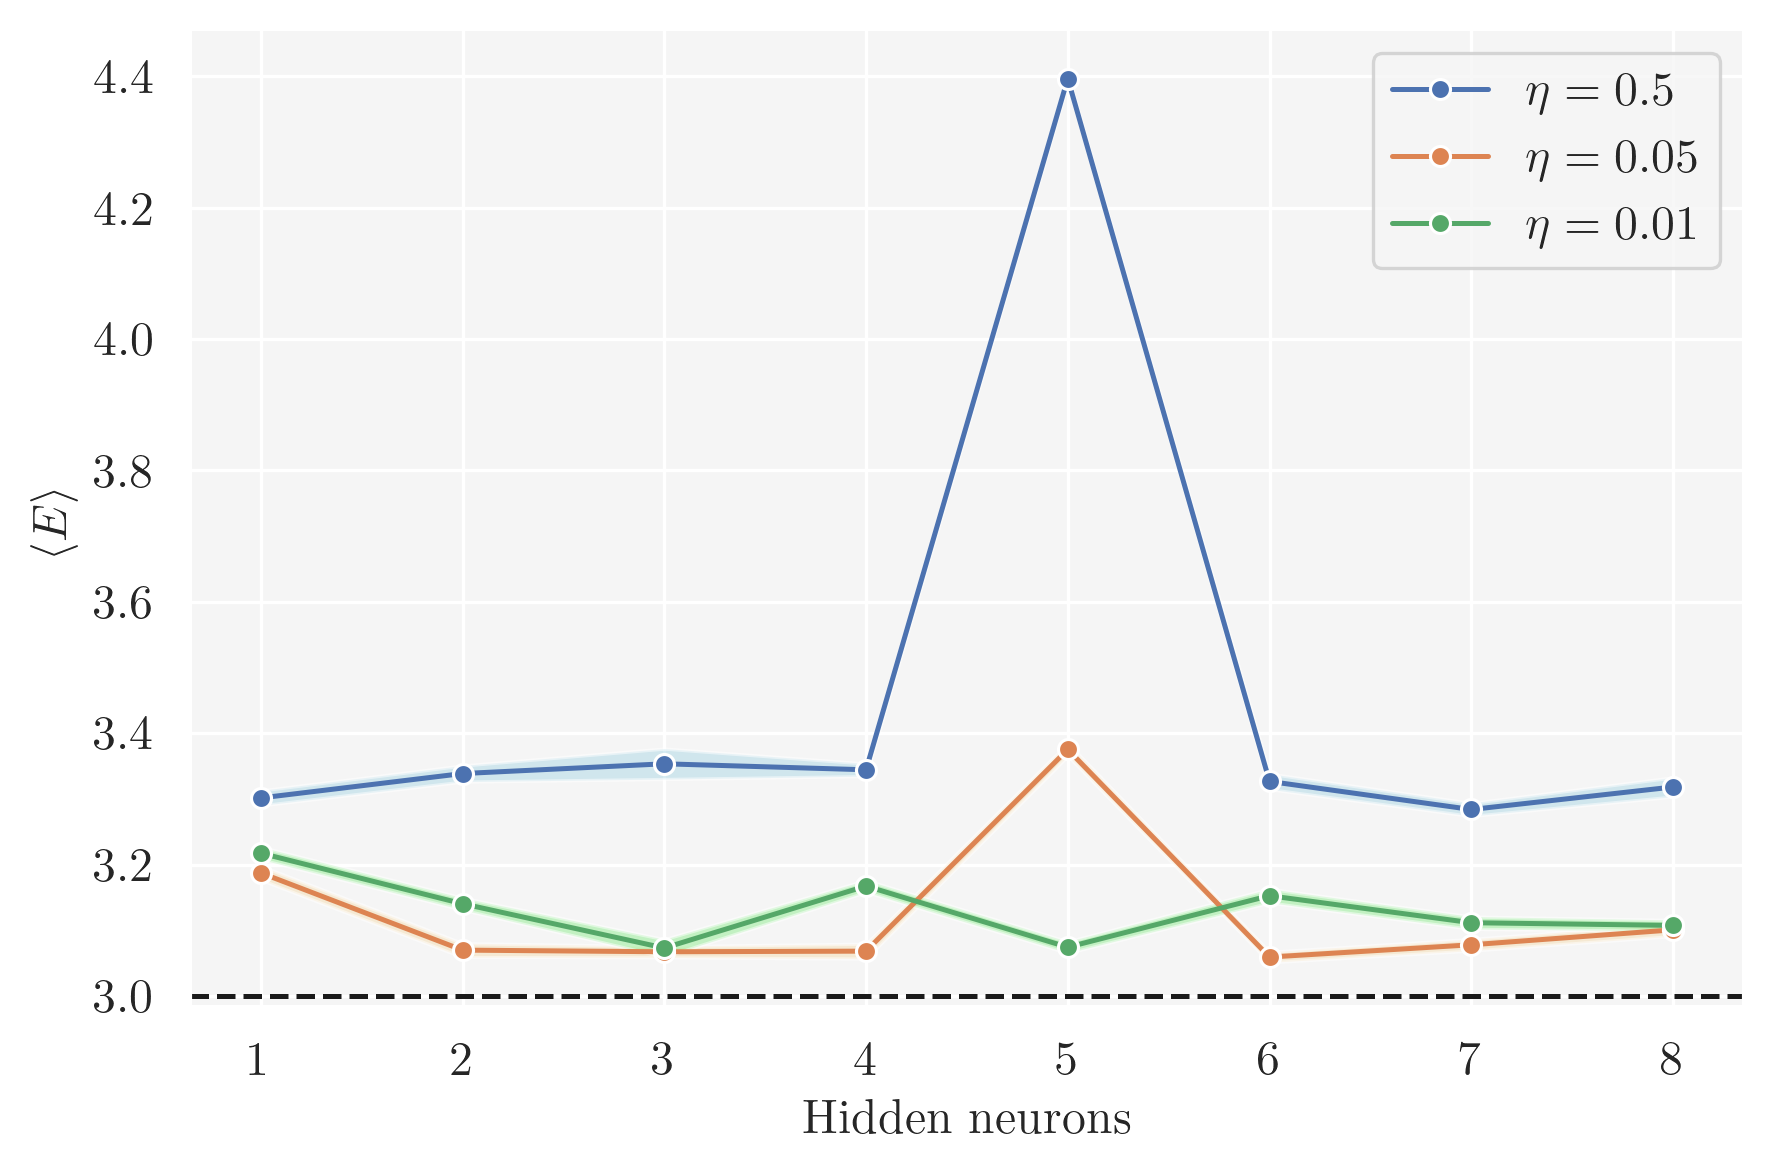

In [14]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=1,
                       figsize=(6, 4), 
                       tight_layout=True,
                       dpi=150
                      )

sns.lineplot(data=df_rwm, 
             x="nhidden",  
             y="energy", 
             marker="o",
             color='C0',
             label=r'$\eta=0.5$',
             ax=ax
            )
ax.fill_between(df_rwm["nhidden"],
                df_rwm["energy"] - df_rwm["std_error"], 
                df_rwm["energy"] + df_rwm["std_error"],
                alpha=0.5,
                facecolor='lightblue')

sns.lineplot(data=df_rwm_lr, 
             x="nhidden",  
             y="energy", 
             marker="o",
             color='C1',
             label=r'$\eta=0.05$',
             ax=ax
            )
ax.fill_between(df_rwm_lr["nhidden"],
                df_rwm_lr["energy"] - df_rwm_lr["std_error"], 
                df_rwm_lr["energy"] + df_rwm_lr["std_error"],
                alpha=0.5,
                facecolor='wheat')

sns.lineplot(data=df_rwm_lr2, 
             x="nhidden",  
             y="energy", 
             marker="o",
             color='C2',
             label=r'$\eta=0.01$',
             ax=ax
            )
ax.fill_between(df_rwm_lr2["nhidden"],
                df_rwm_lr2["energy"] - df_rwm_lr2["std_error"], 
                df_rwm_lr2["energy"] + df_rwm_lr2["std_error"],
                alpha=0.5,
                facecolor='lightgreen')

ax.axhline(3.0, ls='--', color='k')
ax.set(ylabel=r'$\langle E \rangle$', xlabel='Hidden neurons')

plt.show()

## 500 000 vs 1 000 000 training cycles, eta=0.05, RWM

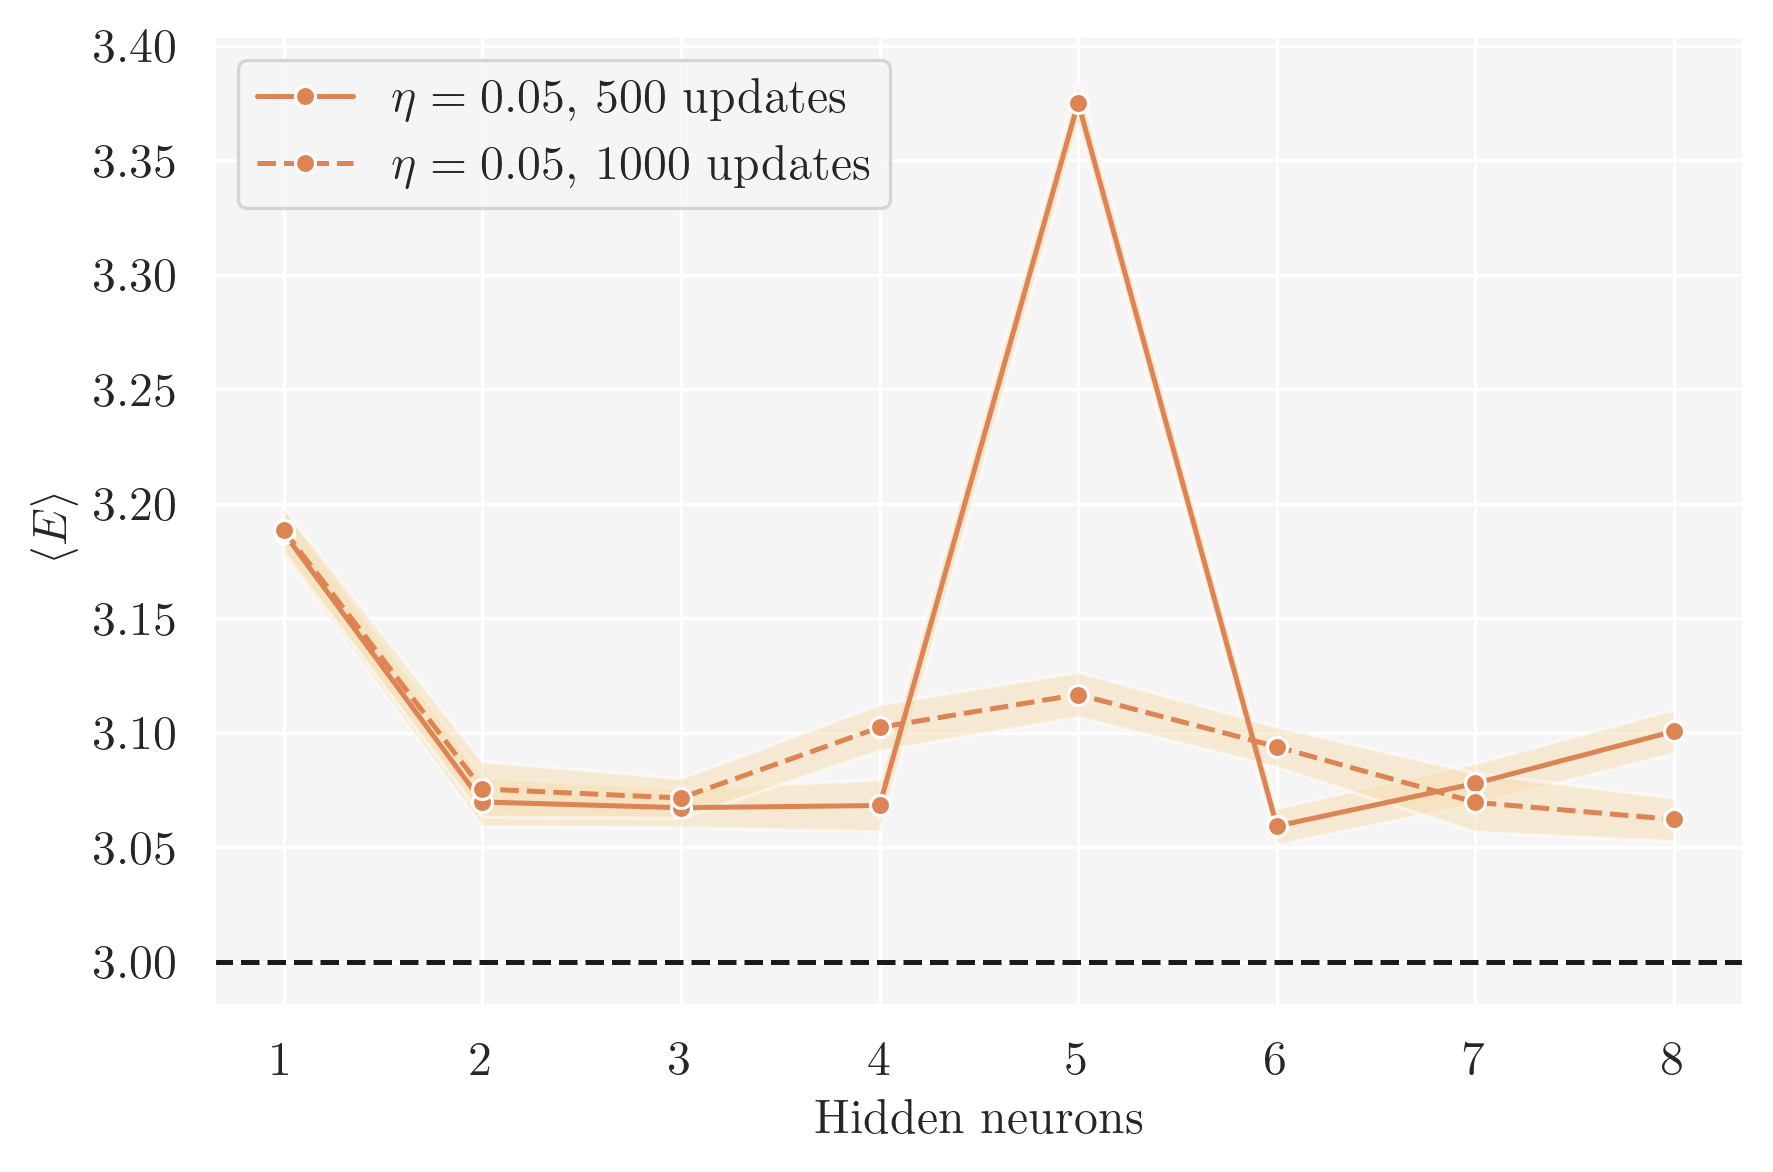

In [12]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=1,
                       figsize=(6, 4), 
                       tight_layout=True,
                       dpi=150
                      )

sns.lineplot(data=df_rwm_lr, 
             x="nhidden",  
             y="energy", 
             marker="o",
             color='C1',
             label=r'$\eta=0.05$, 500 updates',
             ax=ax
            )
ax.fill_between(df_rwm_lr["nhidden"],
                df_rwm_lr["energy"] - df_rwm_lr["std_error"], 
                df_rwm_lr["energy"] + df_rwm_lr["std_error"],
                alpha=0.5,
                facecolor='wheat')

sns.lineplot(data=df_rwm_lr_tr2, 
             x="nhidden",  
             y="energy", 
             marker="o",
             linestyle='--',
             color='C1',
             label=r'$\eta=0.05$, 1000 updates',
             ax=ax
            )
ax.fill_between(df_rwm_lr_tr2["nhidden"],
                df_rwm_lr_tr2["energy"] - df_rwm_lr_tr2["std_error"], 
                df_rwm_lr_tr2["energy"] + df_rwm_lr_tr2["std_error"],
                alpha=0.5,
                facecolor='wheat')

ax.axhline(3.0, ls='--', color='k')
ax.set(ylabel=r'$\langle E \rangle$', xlabel='Hidden neurons')

plt.show()

## One fig

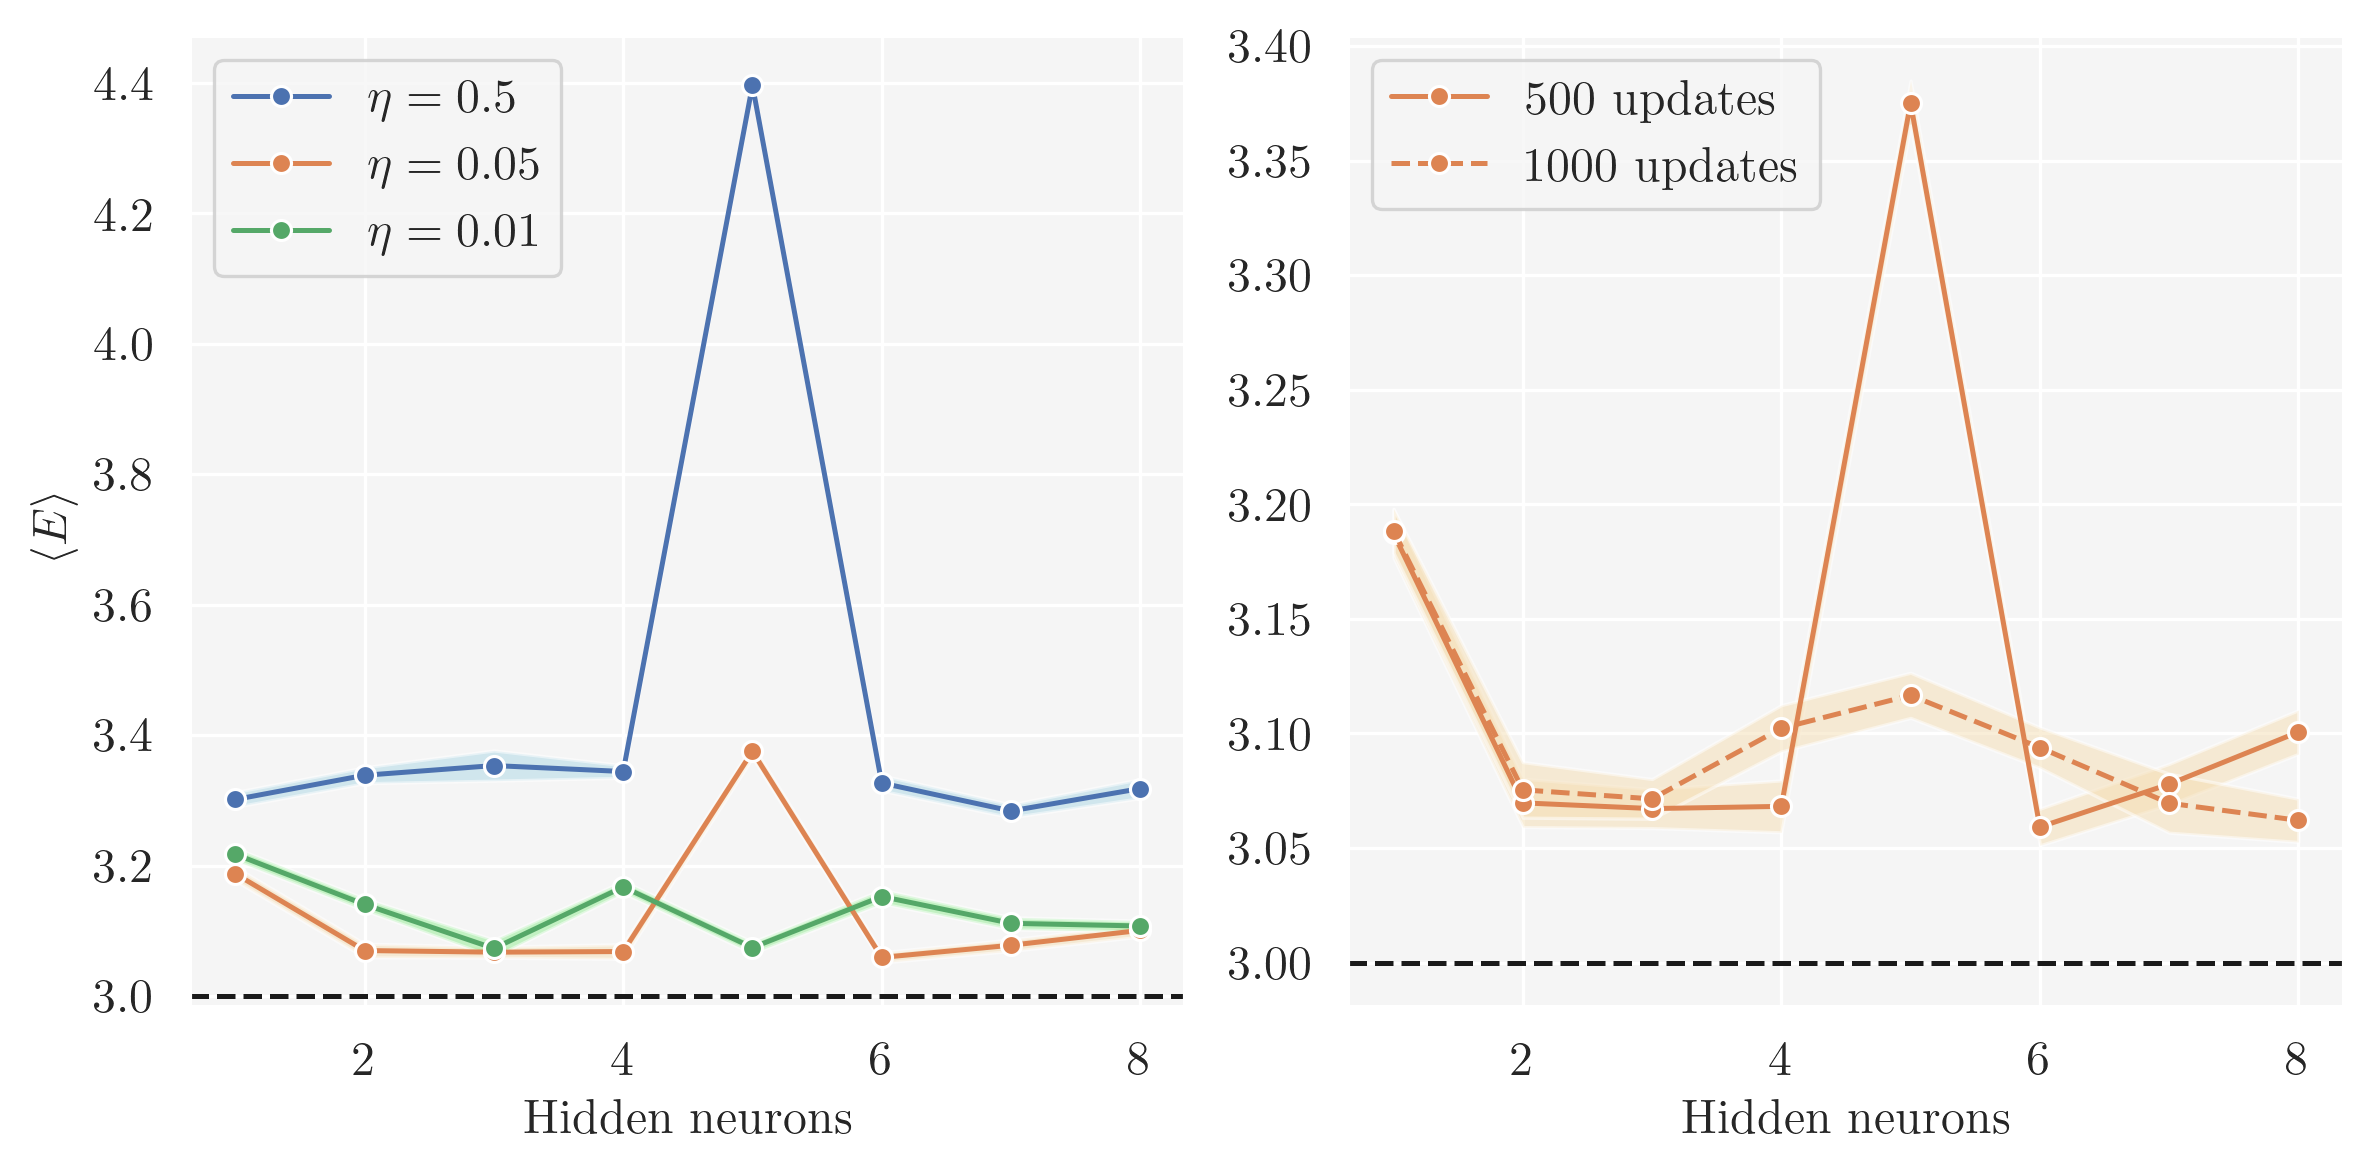

In [28]:
fig, axes = plt.subplots(nrows=1, 
                         ncols=2, 
                         figsize=(8, 4), 
                         tight_layout=True,
                         sharex='col', #True,
                         #sharey='row', #True,
                         dpi=150
                        )

#### Upper left

sns.lineplot(data=df_rwm, 
             x="nhidden",  
             y="energy", 
             marker="o",
             color='C0',
             label=r'$\eta=0.5$',
             ax=axes[0]
            )
axes[0].fill_between(df_rwm["nhidden"],
                df_rwm["energy"] - df_rwm["std_error"], 
                df_rwm["energy"] + df_rwm["std_error"],
                alpha=0.5,
                facecolor='lightblue')

sns.lineplot(data=df_rwm_lr, 
             x="nhidden",  
             y="energy", 
             marker="o",
             color='C1',
             label=r'$\eta=0.05$',
             ax=axes[0]
            )
axes[0].fill_between(df_rwm_lr["nhidden"],
                df_rwm_lr["energy"] - df_rwm_lr["std_error"], 
                df_rwm_lr["energy"] + df_rwm_lr["std_error"],
                alpha=0.5,
                facecolor='wheat')

sns.lineplot(data=df_rwm_lr2, 
             x="nhidden",  
             y="energy", 
             marker="o",
             color='C2',
             label=r'$\eta=0.01$',
             ax=axes[0]
            )
axes[0].fill_between(df_rwm_lr2["nhidden"],
                df_rwm_lr2["energy"] - df_rwm_lr2["std_error"], 
                df_rwm_lr2["energy"] + df_rwm_lr2["std_error"],
                alpha=0.5,
                facecolor='lightgreen')

axes[0].axhline(3.0, ls='--', color='k')
axes[0].set(ylabel=r'$\langle E \rangle$', xlabel='Hidden neurons')
axes[0].legend(loc='upper left')

#### Upper right
sns.lineplot(data=df_rwm_lr, 
             x="nhidden",  
             y="energy", 
             marker="o",
             color='C1',
             label=r'500 updates',
             ax=axes[1]
            )
axes[1].fill_between(df_rwm_lr["nhidden"],
                df_rwm_lr["energy"] - df_rwm_lr["std_error"], 
                df_rwm_lr["energy"] + df_rwm_lr["std_error"],
                alpha=0.5,
                facecolor='wheat')

sns.lineplot(data=df_rwm_lr_tr2, 
             x="nhidden",  
             y="energy", 
             marker="o",
             linestyle='--',
             color='C1',
             label=r'1000 updates',
             ax=axes[1]
            )
axes[1].fill_between(df_rwm_lr_tr2["nhidden"],
                df_rwm_lr_tr2["energy"] - df_rwm_lr_tr2["std_error"], 
                df_rwm_lr_tr2["energy"] + df_rwm_lr_tr2["std_error"],
                alpha=0.5,
                facecolor='wheat')

axes[1].axhline(3.0, ls='--', color='k')
axes[1].set(ylabel='', xlabel='Hidden neurons')
axes[1].legend(loc='upper left')

# Save figure
fig.savefig(fig_path("interacting_eta.pdf"), bbox_inches='tight')

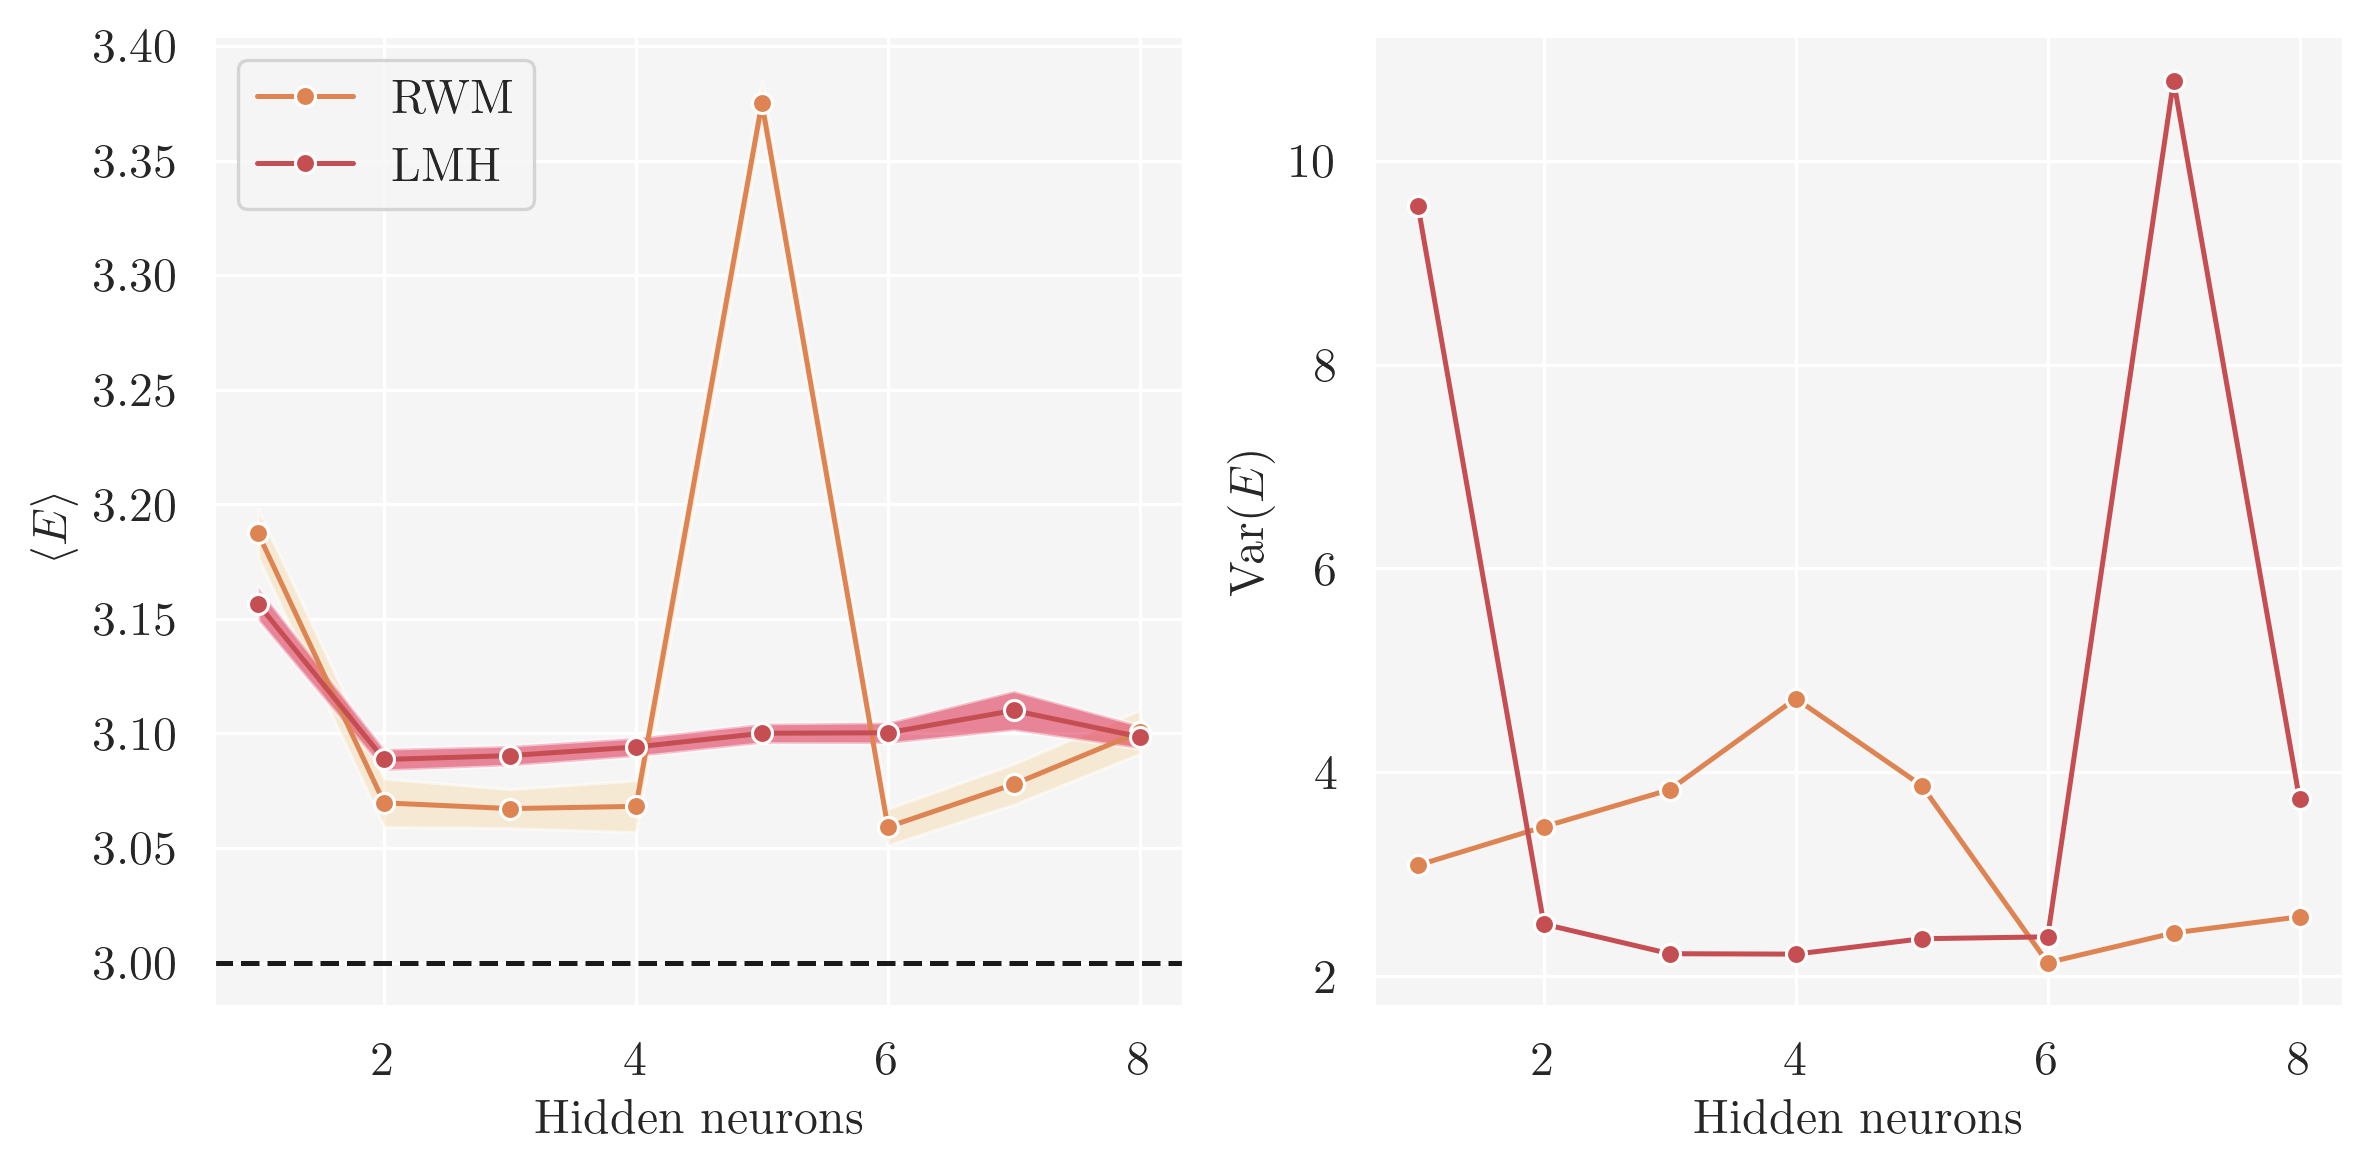

In [29]:
fig, axes = plt.subplots(nrows=1, 
                         ncols=2, 
                         figsize=(8, 4), 
                         tight_layout=True,
                         #sharex='col', #True,
                         #sharey='row', #True,
                         dpi=150
                        )

#### Upper left


sns.lineplot(data=df_rwm_lr, 
             x="nhidden",  
             y="energy", 
             marker="o",
             color='C1',
             label=r'RWM',
             ax=axes[0]
            )
axes[0].fill_between(df_rwm_lr["nhidden"],
                df_rwm_lr["energy"] - df_rwm_lr["std_error"], 
                df_rwm_lr["energy"] + df_rwm_lr["std_error"],
                alpha=0.5,
                facecolor='wheat')

sns.lineplot(data=df_lmh, 
             x="nhidden",  
             y="energy", 
             marker="o",
             color='C3',
             label=r'LMH',
             ax=axes[0]
            )
axes[0].fill_between(df_lmh["nhidden"],
                df_lmh["energy"] - df_lmh["std_error"], 
                df_lmh["energy"] + df_lmh["std_error"],
                alpha=0.5,
                facecolor='crimson')

axes[0].axhline(3.0, ls='--', color='k')
axes[0].set(ylabel=r'$\langle E \rangle$', xlabel='Hidden neurons')
axes[0].legend(loc='upper left')

sns.lineplot(data=df_rwm_lr, 
             x="nhidden",  
             y="variance", 
             marker="o",
             color='C1',
             ax=axes[1]
            )
sns.lineplot(data=df_lmh, 
             x="nhidden",  
             y="variance", 
             marker="o",
             color='C3',
             ax=axes[1]
            )

axes[1].set(ylabel=r'$\mathrm{Var}(E)$', xlabel='Hidden neurons')

# Save figure
fig.savefig(fig_path("interacting_rwm_vs_lmh.pdf"), bbox_inches='tight')